In [11]:
%matplotlib inline

In [59]:
import os
from __future__ import print_function, division
import numpy as np, scipy as sp, pandas as pd
import scipy.io
import scipy.signal as signal
import scipy.fftpack as ftpk
import matplotlib.pyplot as plt
import matplotlib

from imp import reload
import auxfilter
import matlabtools
import glob

In [162]:
# os.chdir('..')
os.chdir('/home/mike/venvs/ml/ml/py')
print(os.getcwd())
from eegkaggle.vectorizers import naive, spectral
from eegkaggle.dio import dataio
from eegkaggle.plotting import plotstuff
from eegkaggle.msignal import wavelets, metrics

/home/mike/venvs/ml/ml/py


In [14]:
matplotlib.style.use('ggplot')

In [15]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = slong

Functions

In [16]:
def pltcwt(plt, my_cwt, widths, realize=None):
    hi = np.max(widths)
    lo = np.min(widths)
    if realize == 'abs':
        my_cwt = np.abs(my_cwt)
    elif realize == 'ang':
        my_cwt = np.angle(my_cwt)
    plt.imshow(my_cwt, extent=[-1, 1, hi, lo], cmap='seismic', aspect='auto',
           vmax=abs(my_cwt).max(), vmin=-abs(my_cwt).max())
    
def plt_easycwt(plt, sig, widths):
    my_cwt = signal.cwt(sig, signal.ricker, widths)
    pltcwt(plt, my_cwt, widths)

Data loading section

In [17]:
basepath = '/home/mike/Downloads/train_1/'
path = basepath + '1_1_1.mat'
rawdata = dataio.get_matlab_eeg_data(path)
data = rawdata['data']
print(data.shape)
SR = rawdata['iEEGsamplingRate'][0][0]
if SR == int(SR):
    SR = int(SR)
print(SR)

(240000, 16)
400


In [18]:
brief = data[:SR*120]
brief.shape

(48000, 16)

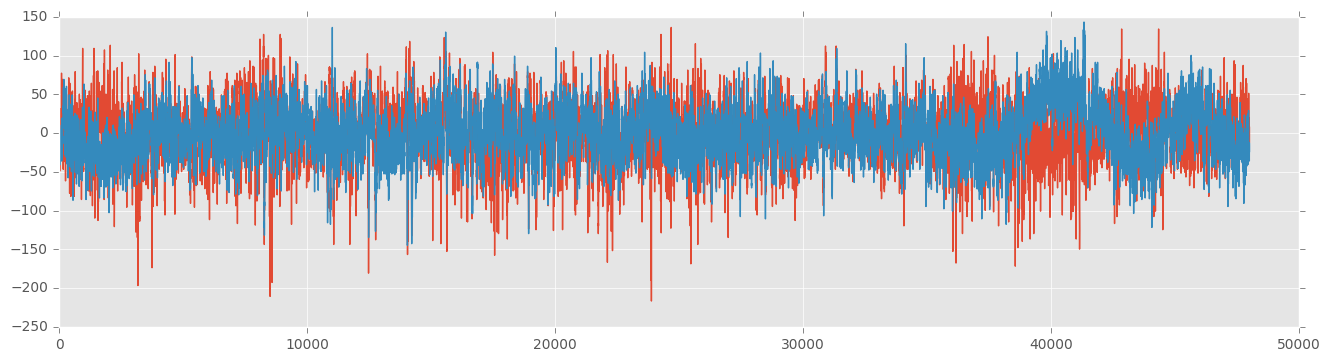

In [19]:
plt.plot(brief[:,:2])

In [20]:
eeg1 = brief[:,0]
eeg2 = brief[:,1]

In [21]:
lo, hi = 1, 16
nbins = 32
widths = np.linspace(lo, hi, nbins)**2

In [22]:
data.shape

(240000, 16)

In [23]:
sig = data[:, 0]
fsig = ftpk.fft(data, axis=0)
t = np.linspace(0, 400, len(fsig))

fsig.shape


(240000, 16)

/home/mike/venvs/ml/ml/local/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


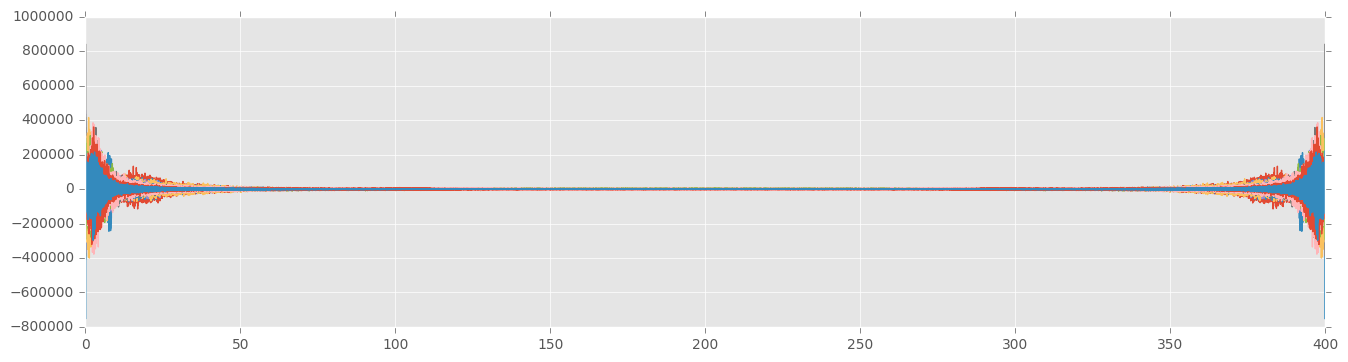

In [24]:
plt.plot(np.linspace(0, 400, len(fsig)), fsig)

In [25]:
sources1 = glob.glob(basepath + '*_1.mat') 
sources0 = glob.glob(basepath + '*_0.mat') 


In [27]:
limit = 20
dataset0 = [ dataio.get_matlab_eeg_data(path)['data'] for path in sources0[:limit]]
dataset1 = [ dataio.get_matlab_eeg_data(path)['data'] for path in sources1[:limit]]


In [28]:
dataset0[0].shape

(240000, 16)

In [29]:
spectra = [ftpk.fft(datas, axis=0) for datas in dataset0]
spectra = np.array(spectra)
spectra1 = np.array([ftpk.fft(datas, axis=0) for datas in dataset1])
spectra.shape

(20, 240000, 16)

In [30]:
flat = np.average(spectra, axis=0)
flatstd = np.std(spectra, axis=0)
flat1 = np.average(spectra1, axis=0)
flatstd1 = np.std(spectra1, axis=0)
flat.shape

(240000, 16)

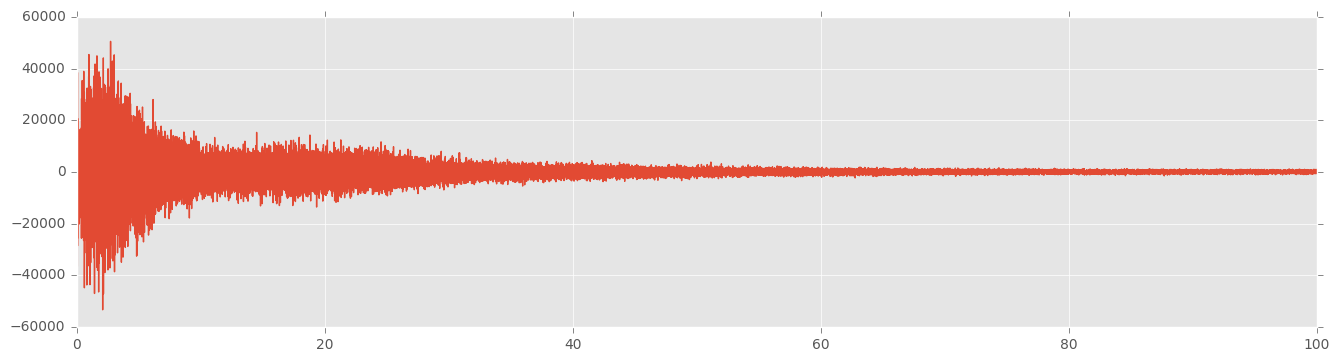

In [31]:
cut = 100*240000/400
plt.plot(t[:cut], flat[:cut,0])

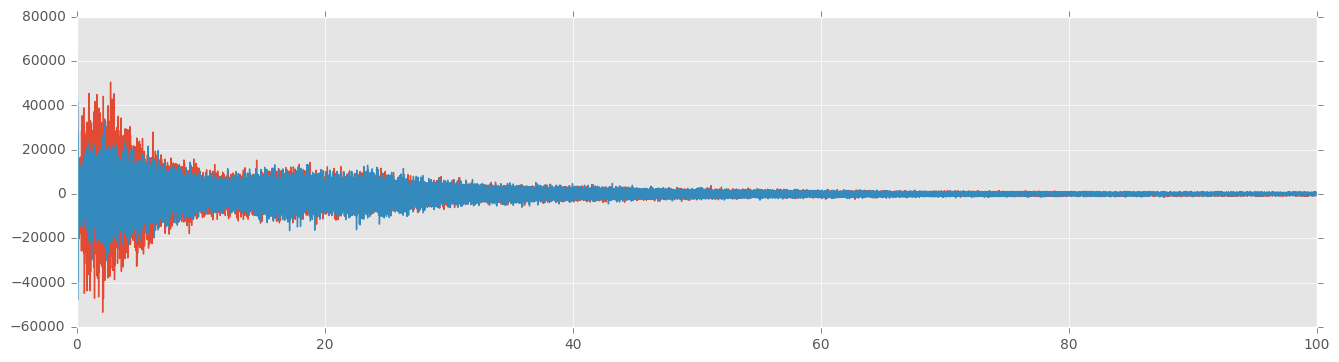

In [32]:
plt.plot(t[:cut], flat[:cut,0])
plt.plot(t[:cut], flat1[:cut,0])

60000

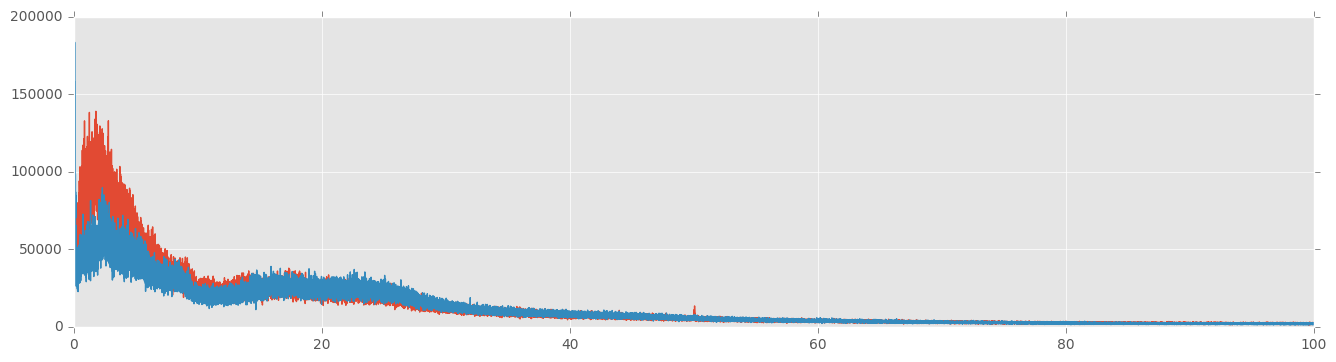

In [33]:
plt.plot(t[:cut], flatstd[:cut,0])
plt.plot(t[:cut], flatstd1[:cut,0])
len(t[:cut])

In [74]:
len(t)/400

600

In [36]:
len(dataset0[0])

240000

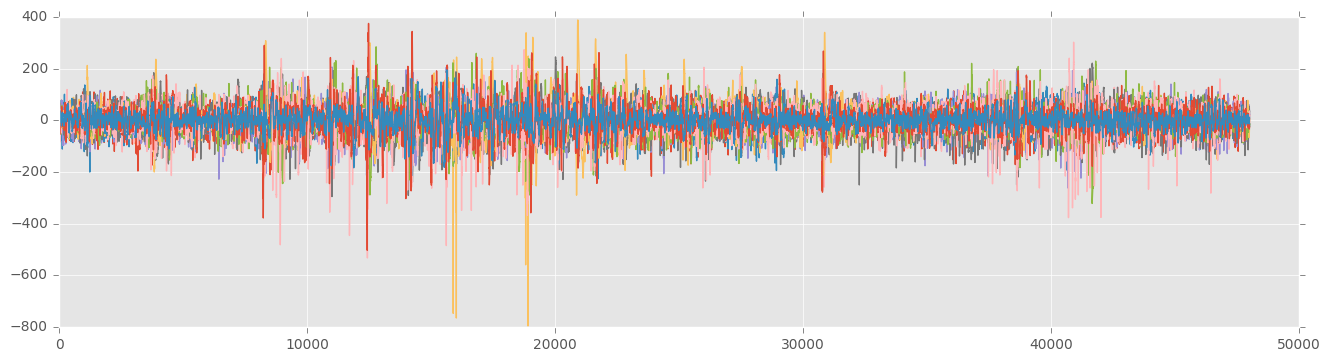

In [34]:
plt.plot(brief)

### Moving on to some Hurst analysis, see if that gives fruitful results. 

In [48]:
h0 = hurst.hurst(dataset0[0])
h1 = hurst.hurst(dataset1[0])
print(dataset0[0].shape)
print(h0, h1)

(240000, 16)
0.652278143134 0.515446134171


In [41]:
h0 = [hurst.hurst(D) for D in dataset0]
h1 = [hurst.hurst(D) for D in dataset1]


(0.55552046745525541, 27.890839)


In [42]:
print(np.mean(h0), np.std(h0))
print(np.mean(h1), np.std(h1))

(0.55552046745525541, 0.066471508927878481)
(0.46559272035890287, 0.080922802486426013)


In [84]:
vc_thresh = .95
h1 = []
for source in sources1:
    D = dataio.get_matlab_eeg_data(source)['data']
    vc = dataio.validcount(D)
    if vc < vc_thresh:
        print('bad', end=' ')
        continue
#     print(D.shape)
    h = hurst.hurst(D)
    print(h, end=' ')
    h1.append(np.array([h,1]))

0.515446134171 0.328435766266 0.577125967051 0.40321881214 0.556201842246 bad 0.381234318929 0.484816684226 0.402147493826 bad 0.395940650478 0.337558806913 0.605293584634 0.474780306389 bad 0.388066229917 0.412067447979 0.437595721161 0.535963951014 0.515343962688 bad 0.654415815257 0.386383971832 bad 0.374992635627 0.435457350028 0.538931752815 0.390925902012 bad 0.620847190352 0.490143586851 bad 0.416554622703 0.633643180206 bad 0.375977567729 0.600861076046 0.43991025668 0.572208345849 0.390076087508 bad 0.475199956575 0.509458548433 0.609703815784 0.553584683792 0.570636434745 0.492597872621 bad 0.426815990185 bad bad 0.537515095499 0.568018420481 bad 0.507008344046 bad bad 0.391526138954 0.572429046338 bad bad bad 0.650592472191 0.587831997364 0.388043679548 0.39256779577 bad 0.341636645275 bad 0.540955905212 bad 0.476882154758 0.396533126525 bad 0.59972926085 0.582066642675 0.612811226427 0.43191347711 0.34544689084 bad 0.380882158406 bad bad 0.466748401369 0.329907371043 bad 0.

In [85]:
h0 = []
for source in sources0[:len(sources1)*2]:
    D = dataio.get_matlab_eeg_data(source)['data']
    vc = dataio.validcount(D)
    if vc < vc_thresh:
        print('bad', end=' ')
        continue
    h = hurst.hurst(D)
    print(h, end=' ')
    h0.append(np.array([h,0]))

0.652278143134 0.567300914295 0.591877061588 0.444552904621 0.408194860216 bad bad bad bad bad bad 0.478767161758 0.568476851744 0.544433946353 0.604412896472 0.593521052199 0.487778470697 0.607527426592 0.527251182853 0.637348847057 bad 0.579807763996 0.322775600128 0.385727234329 0.403982500466 bad bad bad 0.50472975864 0.420088081938 0.654179143216 bad bad 0.600710511914 bad 0.421146772008 0.561377305473 0.630697233385 0.616711799889 0.653658540106 0.416857250825 0.320129196794 bad bad 0.648508937057 0.526129827698 bad 0.565853675849 0.660097094348 0.573465460677 0.631213978354 bad 0.585518839882 bad 0.620318299687 0.521370809027 0.563214440462 0.562002931688 0.382829131246 0.525582241072 0.64518342065 0.255651642843 0.416407369538 bad bad bad 0.519129900521 0.525840899128 bad 0.625233244109 0.601734714094 0.564019603732 0.533241478167 0.566630502774 bad 0.657638527738 bad bad bad 0.623393284466 0.58865011244 0.625125285244 0.652797294231 bad bad 0.625124310291 0.56685055572 bad 0.5

In [64]:
len(h0), len(h1)

(220, 101)

In [86]:
h0 = np.nan_to_num(h0)
h1 = np.nan_to_num(h1)

In [87]:
print(np.mean(h0[:,0]), np.std(h0[:,0]))
print(np.mean(h1[:,0]), np.std(h1[:,0]))

0.530773728059 0.10119771358
0.480811157271 0.0910187874824


### Looks a little disappointing. Certainly not a big effect. However, we haven't dealt with dropout yet. Re-doing with dropout filter

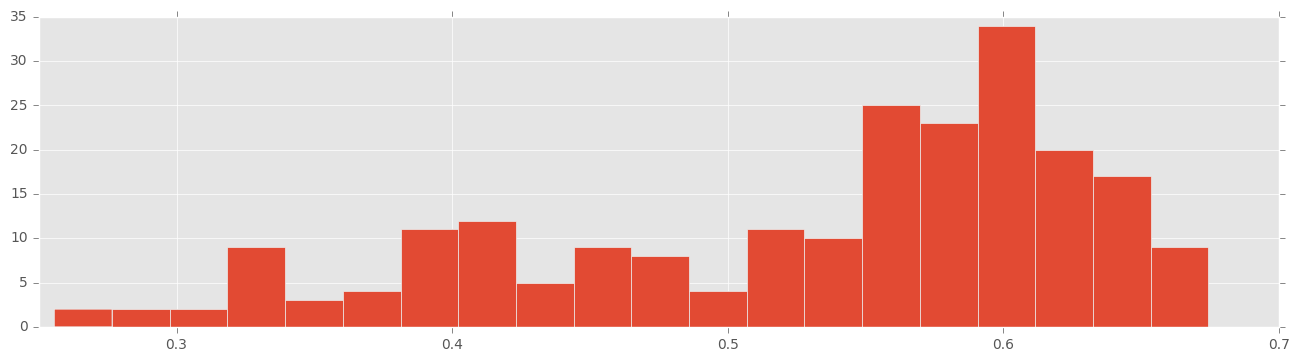

In [89]:
pd.Series(h0[:,0]).hist(bins=20)

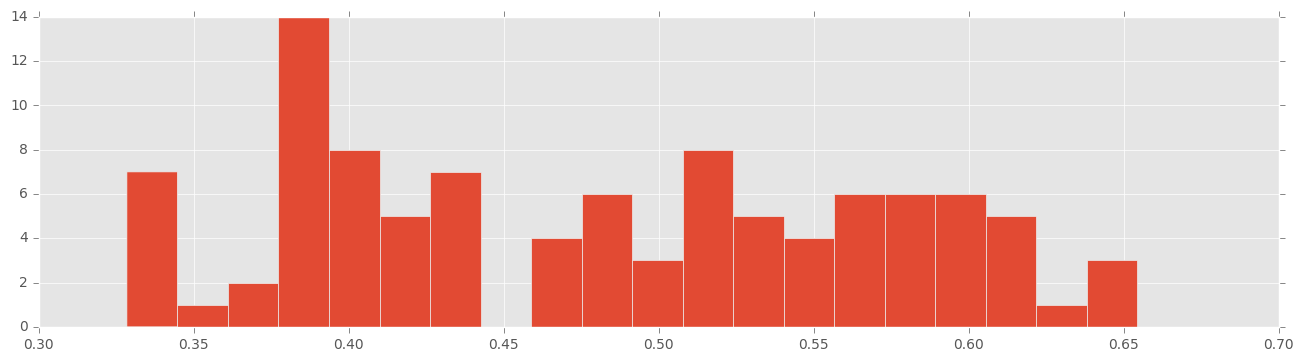

In [90]:
pd.Series(h1[:,0]).hist(bins=20)

### Ok, that is actually quite a different distribution. I think I am on to something. It alone is probably insignificant, but combined with the other vectors, and also looking at channel-by-channel.
#### Looks like Hu < 0.5 is decent evidence of something screwy going on. 

In [91]:
thresh = .5
pH_05_0 = np.mean(h0[:,0] > thresh)
pH_05_1 = np.mean(h1[:,0] > thresh)
pT_H_05 = np.mean(np.concatenate([h0, h1], axis=0))
pS =  len(h1)/(len(h1) + len(h0))
print(pH_05_0, pH_05_1, pT_H_05, pS)

0.686363636364 0.445544554455 0.414847581086 0.314641744548


$ P(H_5 \mid \bar S) = .69$

$ P(H_5 \mid S) = .45$

In [83]:
pbayes = pH_05_1*pS / pT_H_05
print('Probability of Seizure given H5 indicator', pbayes)
print('Probability of Seizure given Hurst < 0.5 ', 1-pbayes)

Probability of Seizure given H5 indicator 0.272179372257
Probability of Seizure given Hurst < 0.5  0.727820627743


In [93]:
testset = np.concatenate([h0, h1])
testset = pd.DataFrame(testset, columns=['h', 's'])
testset['guess'] = testset['h'] < thresh

In [94]:
testset['score'] = testset['guess'] == testset['s']

In [95]:
testset['score'].mean()

0.64485981308411211

Ok, well that's something

## Applying to train set 3

In [168]:
basepath = '/media/mike/Elements/data/kaggle/melbourne/train_3/'
basepathT = '/media/mike/Elements/data/kaggle/melbourne/test_3/'

sources1 = glob.glob(basepath + '*_1.mat') 
sources0 = glob.glob(basepath + '*_0.mat') 
sourcesT = glob.glob(basepath + '*.mat') 

In [99]:
vc_thresh = .95
h1 = []
for source in sources1:
    D = dataio.get_matlab_eeg_data(source)['data']
    vc = dataio.validcount(D)
    if vc < vc_thresh:
        print('bad', end=' ')
        continue
#     print(D.shape)
    h = hurst.hurst(D)
    print('{:.2}'.format(h), end=' ')
    h1.append(np.array([h,1]))

print('\nNext set\n')
h0 = []
for source in sources0[:len(sources1)*2]:
    D = dataio.get_matlab_eeg_data(source)['data']
    vc = dataio.validcount(D)
    if vc < vc_thresh:
        print('bad', end=' ')
        continue
    h = hurst.hurst(D)
    print('{:.2}'.format(h), end=' ')
    h0.append(np.array([h,0]))

0.51 0.55 0.64 0.65 0.66 0.66 0.63 0.66 0.67 0.68 0.65 0.56 0.65 0.64 0.62 0.63 0.62 bad 0.47 0.51 0.53 0.52 0.55 0.57 0.53 0.6 0.58 0.64 0.63 0.66 0.64 0.6 0.5 0.67 0.71 0.7 0.67 0.69 bad 0.63 0.7 0.7 bad 0.7 bad bad bad bad 0.69 bad bad 0.62 0.63 0.69 0.63 0.66 0.67 0.65 0.66 0.65 0.6 0.61 0.63 0.61 0.6 0.61 0.61 0.66 0.68 0.67 0.65 0.65 0.64 0.67 0.68 0.65 bad 0.67 0.49 0.49 0.49 0.69 0.68 0.67 0.56 0.62 0.62 0.67 0.69 0.67 0.65 0.68 0.63 0.57 0.55 0.54 0.55 0.53 0.58 0.65 0.66 0.66 0.65 0.63 0.57 0.59 0.49 0.47 0.46 0.45 0.49 0.47 0.5 0.59 0.56 0.69 0.57 0.61 0.61 0.67 0.68 0.59 0.59 0.64 0.64 0.64 0.66 0.67 0.57 0.57 0.58 0.58 0.6 0.6 0.64 0.69 0.62 0.68 0.71 0.68 0.56 0.61 0.6 bad 0.56 0.61 0.55 0.61 0.61 0.55 Next set

0.67 bad 0.67 0.74 0.72 0.73 0.72 0.71 0.73 0.73 0.64 0.72 0.7 0.72 0.71 0.68 0.67 0.68 0.68 0.66 0.63 0.65 0.61 0.63 0.64 0.61 0.6 0.62 0.64 0.63 0.65 0.62 0.65 0.66 0.61 0.66 0.64 0.64 0.59 0.63 0.7 0.62 0.67 0.68 0.71 0.72 0.71 0.66 0.67 0.66 0.67 0.73 0.67 0.6

In [101]:
h0 = np.nan_to_num(h0)
h1 = np.nan_to_num(h1)

In [161]:
print(np.mean(h0[:,0]), np.std(h0[:,0]), np.median(h0[:,0]))
print(np.mean(h1[:,0]), np.std(h1[:,0]), np.median(h1[:,0]))

0.670675957202 0.0471653392424 0.671394736614
0.614324235572 0.0622970545983 0.628322100425


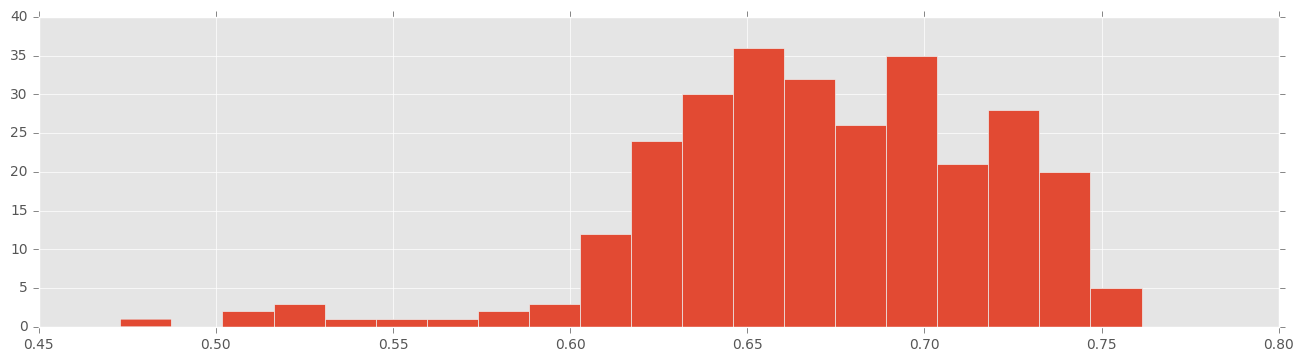

In [102]:
pd.Series(h0[:,0]).hist(bins=20)

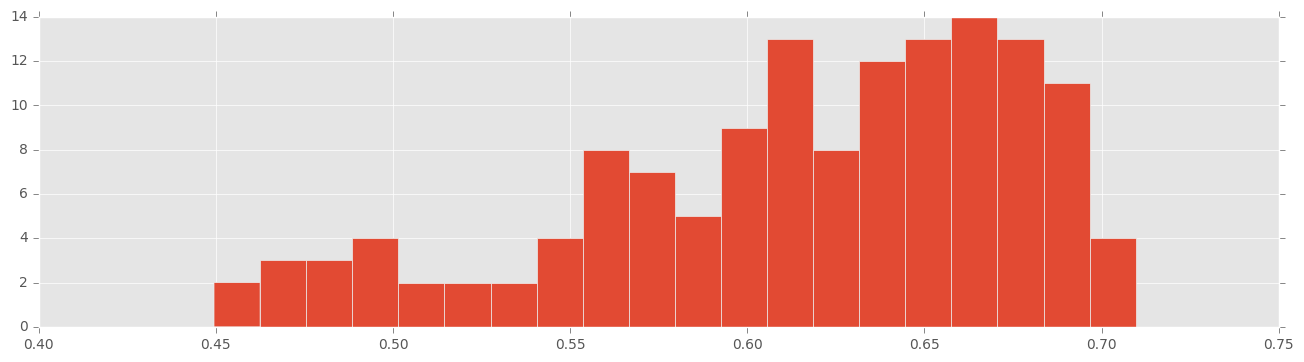

In [103]:
pd.Series(h1[:,0]).hist(bins=20)

## Lovely. The baseline has changed. Fortunately, the trend in H overall stays the same

In [151]:
thresh = .66
pH_05_0 = np.mean(h0[:,0] > thresh)
pH_05_1 = np.mean(h1[:,0] > thresh)
pT_H_05 = np.mean(np.concatenate([h0, h1], axis=0))
pS =  len(h1)/(len(h1) + len(h0))
print(pH_05_0, pH_05_1, pT_H_05, pS)

pbayes = pH_05_1*pS / pT_H_05
print(pbayes)
baysmin.append(pbayes)

0.597173144876 0.294964028777 0.490749247195 0.329383886256
0.197975643691


In [114]:
baysmin = []
X = np.arange(.4,.9,0.0001)
for i in X:
    thresh = iA
    pH_05_0 = np.mean(h0[:,0] > thresh)
    pH_05_1 = np.mean(h1[:,0] > thresh)
    pT_H_05 = np.mean(np.concatenate([h0, h1], axis=0))
    pS =  len(h1)/(len(h1) + len(h0))
#     print(pH_05_0, pH_05_1, pT_H_05, pS)

    pbayes = pH_05_1*pS / pT_H_05
#     print(pbayes)
    baysmin.append(pbayes)

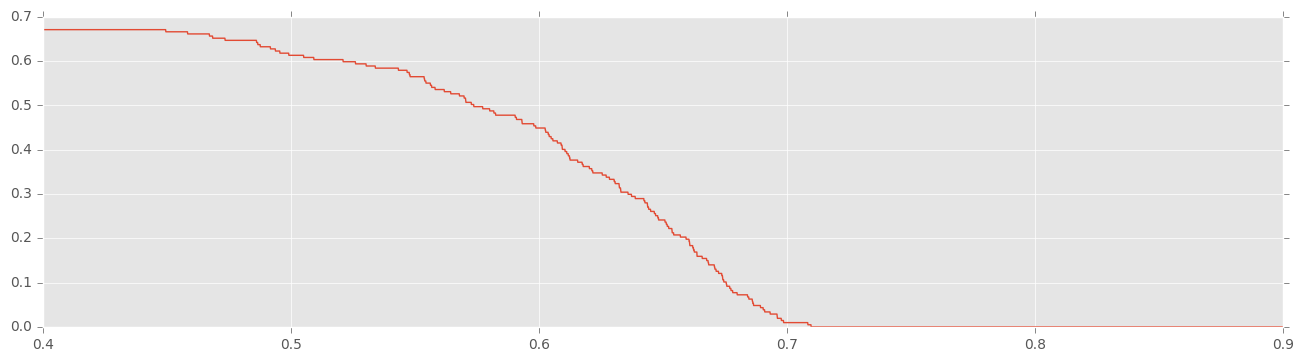

In [118]:
plt.plot(X, baysmin)

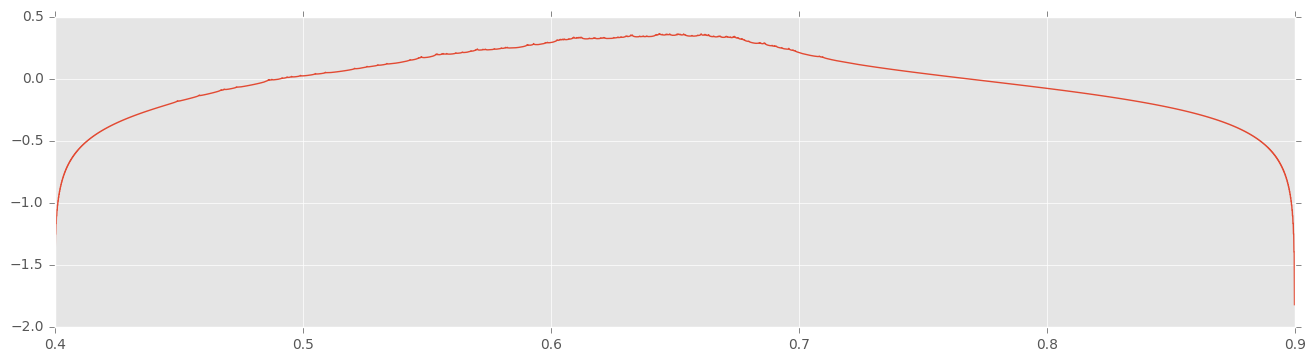

In [117]:
plt.plot(X, np.imag(signal.hilbert(baysmin)))

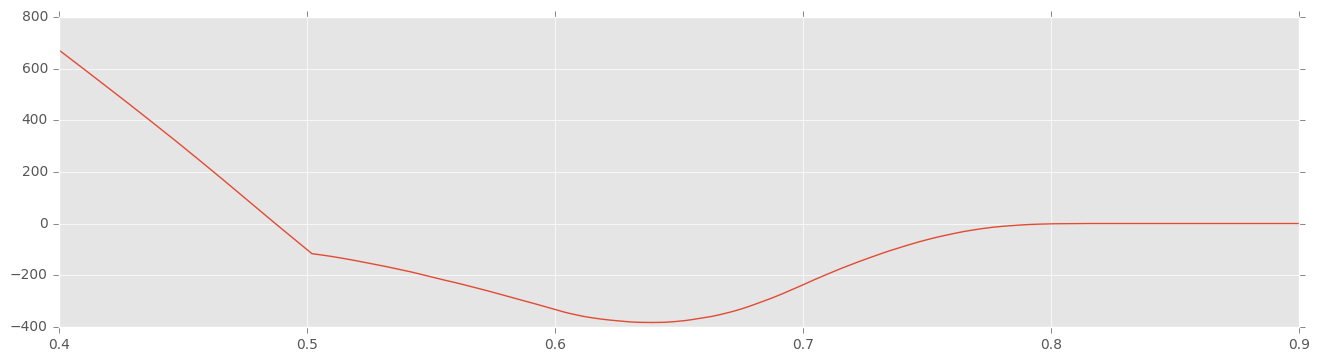

In [145]:
plt.plot(X, signal.cwt(baysmin, wavelets.CWTlets.haar, np.arange(10, 1000, 100))[5])

In [125]:
peaks = signal.find_peaks_cwt(np.imag(signal.hilbert(baysmin)), np.arange(200, 250))
print([X[peak] for peak in peaks])

[0.46019999999999339, 0.55919999999998249, 0.66579999999997075, 0.84229999999995131]


In [160]:
thresh = 0.61#0.6658
testset = np.concatenate([h0, h1])
testset = pd.DataFrame(testset, columns=['h', 's'])
testset['guess'] = testset['h'] < thresh
testset['score'] = testset['guess'] == testset['s']
print(testset['score'].mean())

0.763033175355


#### So why did the Bayes estimator not work as well? I don't think I found the maximum right. 
#### actually, the weighted average of ( mean of the S and N data sets)  looks pretty close. Wonder if that is a coincidence. 

## ChanStd worked rather well. going to try on larger set

In [163]:
vc_thresh = .95
h1 = []
for source in sources1:
    D = dataio.get_matlab_eeg_data(source)['data']
    vc = dataio.validcount(D)
    if vc < vc_thresh:
        print('bad', end=' ')
        continue
#     print(D.shape)
    h = metrics.chanstd(D)
    print('{:.2}'.format(h), end=' ')
    h1.append(np.array([h,1]))

print('\nNext set\n')
h0 = []
for source in sources0[:len(sources1)*2]:
    D = dataio.get_matlab_eeg_data(source)['data']
    vc = dataio.validcount(D)
    if vc < vc_thresh:
        print('bad', end=' ')
        continue
    h = metrics.chanstd(D)
    print('{:.2}'.format(h), end=' ')
    h0.append(np.array([h,0]))
    
h0 = np.nan_to_num(h0)
h1 = np.nan_to_num(h1)

1.3e+01 1.7e+01 1.9e+01 1.2e+01 1.3e+01 1.3e+01 2.4e+01 1.2e+01 1.5e+01 1.4e+01 1.3e+01 8.7 1.5e+01 1.3e+01 1.2e+01 1.2e+01 1.1e+01 bad 1.4e+01 1.4e+01 2e+01 1.5e+01 8.5 2.2e+01 2e+01 2.7e+01 1.8e+01 2.3e+01 1.9e+01 1.5e+01 1.3e+01 1.1e+01 6.9 2.2e+01 2.7e+01 2.6e+01 1.5e+01 1.5e+01 bad 9.6 1.8e+01 2e+01 bad 2.2e+01 bad bad bad bad 1.7e+01 bad bad 9.5 9.4 2e+01 1.3e+01 1.4e+01 1.8e+01 1.7e+01 1.7e+01 1.7e+01 1.2e+01 1.8e+01 1.3e+01 1.2e+01 1.1e+01 1.3e+01 1.1e+01 1.6e+01 1.9e+01 1.4e+01 1.5e+01 1.2e+01 1.6e+01 1.3e+01 1.6e+01 1.3e+01 bad 1.5e+01 1e+01 1e+01 1.1e+01 1.9e+01 1.5e+01 1.5e+01 1.4e+01 1e+01 1.1e+01 1.2e+01 1.4e+01 1.5e+01 1.1e+01 1.4e+01 9.6 7.2 7.0 6.8 6.9 6.0 1.4e+01 1.2e+01 1.1e+01 1.1e+01 2e+01 1e+01 7.2 8.5 9.1 8.4 7.3 6.9 9.4 1.2e+01 9.7 1.4e+01 1.1e+01 2e+01 8.1 9.2 8.7 1.5e+01 1.9e+01 9.3 8.7 1.3e+01 1.3e+01 1.3e+01 1.4e+01 1.5e+01 8.3 8.4 8.6 8.4 9.0 9.3 1.2e+01 1.8e+01 1.4e+01 1.8e+01 2e+01 1.9e+01 8.5 9.5 9.1 bad 1.1e+01 9.4 1.5e+01 1.3e+01 1.5e+01 8.4 
Next set


In [165]:
h0 = np.nan_to_num(h0)
h1 = np.nan_to_num(h1)

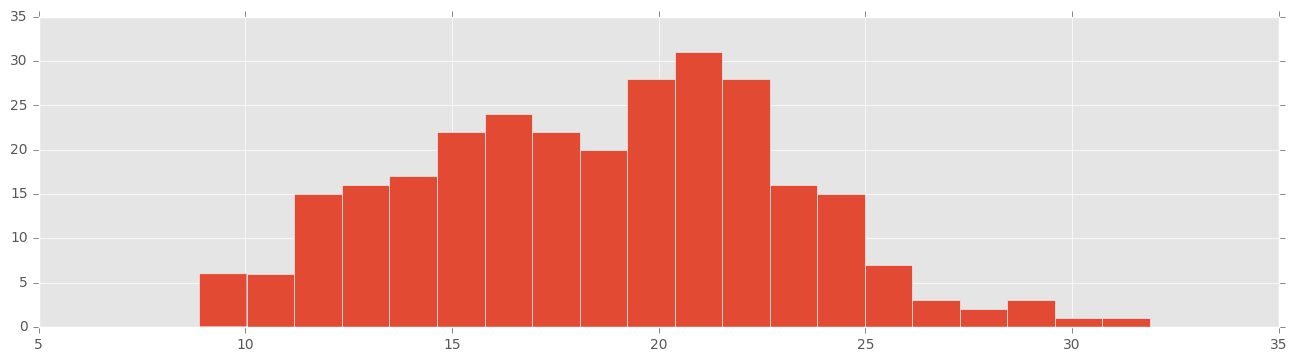

In [166]:
pd.Series(h0[:,0]).hist(bins=20)

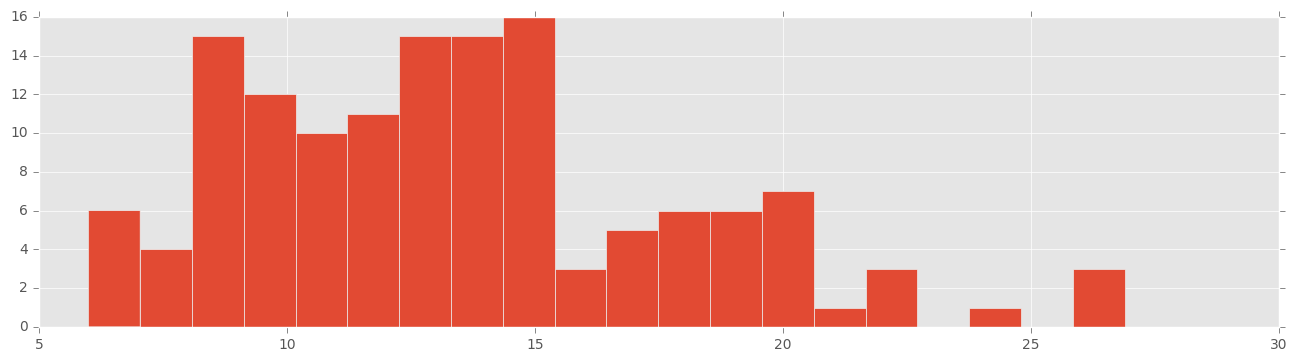

In [167]:
pd.Series(h1[:,0]).hist(bins=20)

In [169]:
vc_thresh = .95
n = 1000
print('\nNext set\n')
hT = []
for source in sourcesT[:n]:
    D = dataio.get_matlab_eeg_data(source)['data']
    vc = dataio.validcount(D)
    if vc < vc_thresh:
        print('bad', end=' ')
        continue
    h = metrics.chanstd(D)
    print('{:.2}'.format(h), end=' ')
    hT.append(np.array([h,0]))
    
hT = np.nan_to_num(hT)


Next set

3.1e+01 bad 2.8e+01 2.1e+01 2.2e+01 2.3e+01 2.5e+01 2.5e+01 2.4e+01 2.2e+01 9.5 1.3e+01 2.3e+01 2.4e+01 2.2e+01 2.3e+01 2.3e+01 2.1e+01 2.1e+01 2.3e+01 2.5e+01 9.2 1.7e+01 2.3e+01 1.7e+01 1.6e+01 1.5e+01 1.3e+01 1.4e+01 1.5e+01 1.7e+01 1.6e+01 1.8e+01 8.9 1.9e+01 1.5e+01 1.9e+01 1.9e+01 2.1e+01 1.7e+01 1.9e+01 1.6e+01 1.5e+01 1.8e+01 1.3e+01 1.2e+01 1.6e+01 1.7e+01 1.7e+01 1.8e+01 1.8e+01 1.4e+01 1.4e+01 1.6e+01 1.7e+01 1.9e+01 1.3e+01 1.7e+01 1.2e+01 1.3e+01 1.3e+01 1.5e+01 1.3e+01 1.2e+01 bad bad bad 2e+01 1.3e+01 2.2e+01 2.2e+01 2.1e+01 2e+01 1.8e+01 1.4e+01 bad 1.8e+01 1.5e+01 1.5e+01 2.6e+01 1.8e+01 1.7e+01 2e+01 2e+01 1.5e+01 2.2e+01 2.1e+01 2.4e+01 1.7e+01 1.7e+01 1.7e+01 2e+01 1.8e+01 1.6e+01 1.9e+01 1.2e+01 1.4e+01 1.4e+01 1.8e+01 1.4e+01 bad 1.3e+01 1.2e+01 1.2e+01 1.1e+01 9.2 1.5e+01 1.7e+01 2.3e+01 2.4e+01 2.3e+01 1.9e+01 1.8e+01 2.1e+01 2e+01 1.9e+01 1.9e+01 1.9e+01 1.4e+01 2.1e+01 2.1e+01 1.7e+01 1.4e+01 1.4e+01 1.5e+01 1.3e+01 1.4e+01 1.2e+01 1.9e+01 1.3e+01 1

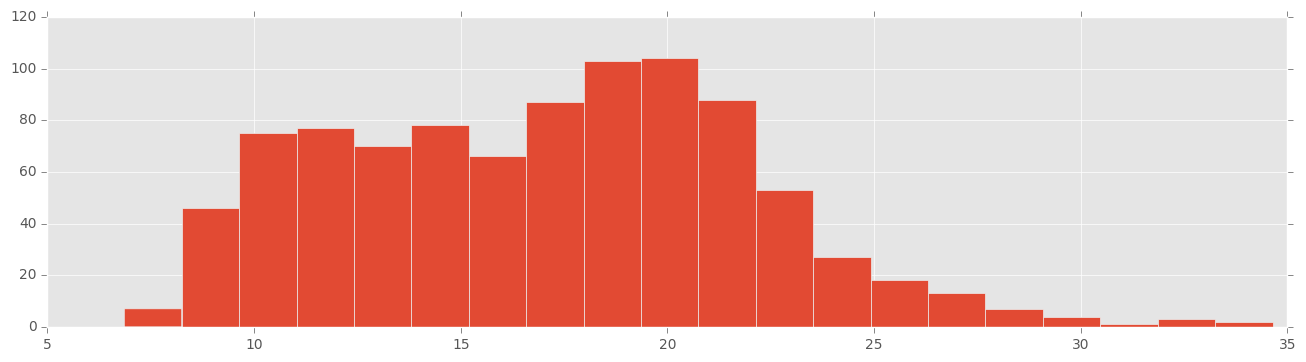

In [170]:
pd.Series(hT[:,0]).hist(bins=20)

NameError: name 'hT' is not defined

In [ ]:
import os
os.path.realpath(sou)